# Convex Optimization Project
## Support Vector Machines solvers

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{-1,1\}$, write a function to solve the classification problem

$$ \begin{array}l
\mathrm{minimize} & \frac12 {||w||}_2^2 + C \mathbf{1}^Tz \\
\mathrm{subject\ to} & y_i(w^Tx_i) \geq 1 - z_i, \quad \forall i \in \{1,\ldots,m\} \\
& z \succcurlyeq 0
\end{array} $$

in the variables $w \in \mathbb{R}^n$, $z \in \mathbb{R}^m$, and its dual (warning: this problem is a bit different from the one in exercise 1).

Solving this problem trains a classifier vector $w$ such that, up to some errors

$$ \begin{array}l
w^Tx_i > 0 & \mathrm{when}\ y_i = 1 \\
w^Tx_i < 0 & \mathrm{when}\ y_i = -1.
\end{array} $$

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^Tx$.

In [1]:
%pylab inline
from scipy.spatial.distance import cdist
import sklearn.svm
import cvxopt

Populating the interactive namespace from numpy and matplotlib


### General optimization functions

In [2]:
def newton(f, gradient_and_hessian, ɛ, x0, α=0.45, β=0.8):
    """
    Newton descent method.
    @param f is the function to minimize
    @param gradient_and_hessian is a function that returns the gradient and the hessian at x
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., f(x0) < +inf
    @param α is a parameter for the backtracking line search
    @param β is a parameter for the backtracking line search
    @return a dictionary
    """    
    x = x0
    assert(f(x0) < float("inf"))
    central_path = [copy(x)]
    while True:
        # Direction computation.
        gradient, hessian = gradient_and_hessian(x)
        hessian_inv = inv(hessian)
        dx = -hessian_inv.dot(gradient)
        
        # Stopping criterion.
        λsquare = gradient.dot(-dx)
        if λsquare/2 <= ɛ:
            break
        
        # Backtracking line search.
        t = 1.0
        f0 = f(x)
        Δ = -λsquare
        # We stop the search if the function starts to increase, which in theory never happens
        # but might be the consequence of a numerical instability.
        prev_fx = float("inf")
        while f(x + t*dx) > f0 + α*t*Δ and (f(x + t*dx) < prev_fx or prev_fx == float("inf")):
            prev_fx = f(x + t*dx)
            t *= β
        
        # Update.
        x += t*dx
        central_path.append(copy(x))
        
    results = {
        "primal_solution":  copy(x),
        "primal_objective": f(x),
        "central_path":     vstack(central_path),
    }
    return results

def barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, t0=1.0, μ=10.0, **newton_params):
    """
    Barrier method for inequality-constrained optimization problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of the f_i(x)
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param t0 is a barrier parameter
    @param μ is a barrier parameter
    @param **newton_params are the additional newton method parameters
    @return a dictionary
    """
    x = x0
    t = t0
    central_path = [copy(x)]
    
    # We minimize objective + 1/t sum (-log(-constraints))
    def f(x):
        cons = constraints(x)
        if any(cons >= 0):
            return float("inf")
        return objective(x) - sum(log(-cons))/t
    def gradient_and_hessian(x):
        obj_g, obj_h = objective_gh(x)
        cons = constraints(x)
        cons_g, cons_h = constraints_gh(x) # shape m,n and m,n,n
        
        # Computing the gradient and hessians of the -log(-f_i(x)).
        div = 1 / cons
        log_cons_g = -cons_g * div[:,None]
        log_cons_h = -cons_h * div[:,None,None] - einsum('ij,ik->ijk', log_cons_g, log_cons_g)
        
        return obj_g + sum(cons_g, axis=0)/t, obj_h + sum(cons_h, axis=0)/t
    
    while True:
        x = newton(f, gradient_and_hessian, ɛ, x, **newton_params)["primal_solution"]
        # Stopping criterion.
        if m/t <= ɛ:
            break
        t *= μ
        central_path.append(copy(x))
    
    cx = constraints(x)
    results = dict()
    results["primal_solution"] = copy(x)
    results["primal_objective"] = f(x)
    results["dual_solution"] = -1/(t*cx)
    results["dual_objective"] = results["primal_objective"] + results["dual_solution"].dot(cx)
    results["central_path"] = vstack(central_path)
    return results

def old_barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, t0=1.0, μ=10.0, **newton_params):
    """
    Barrier method for inequality-constrained optimization problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of sum(-log(-fi(x)))
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param t0 is a barrier parameter
    @param μ is a barrier parameter
    @param **newton_params are the additional newton method parameters
    @return a dictionary
    """
    x = x0
    t = t0
    central_path = [copy(x)]
    
    # We minimize objective + 1/t sum (-log(-constraints))
    def f(x):
        cons = constraints(x)
        if any(cons >= 0):
            return float("inf")
        return objective(x) - sum(log(-cons))/t
    def gradient_and_hessian(x):
        obj_g, obj_h = objective_gh(x)
        cons_g, cons_h = constraints_gh(x)
        return obj_g + cons_g/t, obj_h + cons_h/t
    
    while True:
        x = newton(f, gradient_and_hessian, ɛ, x, **newton_params)["primal_solution"]
        # Stopping criterion.
        if m/t <= ɛ:
            break
        t *= μ
        central_path.append(copy(x))
    
    cx = constraints(x)
    results = dict()
    results["primal_solution"] = copy(x)
    results["primal_objective"] = f(x)
    results["dual_solution"] = -1/(t*cx)
    results["dual_objective"] = results["primal_objective"] + results["dual_solution"].dot(cx)
    results["central_path"] = vstack(central_path)
    return results

def phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params):
    """
    Computes a strictly feasible point by solving the following problem: min s subject to f_i(x) <= s*1_m.
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of the f_i(x)
    @param ɛ is the required absolute precision
    @param **barrier_params are the additional barrier method parameters
    @return a strictly feasible point, or None if no such point exists
    """
    # The variable v is the concatenation of s and x.
    x0 = zeros(n)
    v0 = concatenate(((1 + max(constraints(x0)))*ones(1), x0))
    
    def obj(v):
        return v[0]
    def obj_gh(v):
        return concatenate((ones(1), zeros(n))), zeros((n+1,n+1))
    def cons(v):
        return constraints(v[1:]) - v[0]
    def cons_gh(v):
        s, x = v[0], v[1:]
        f_i = constraints(x) # shape m
        gradients_f_i, hessians_f_i = constraints_gh(x) # shape m,n and m,n,n
        print(m, n, hessians_f_i.shape)
        
        div = 1 / (s - f_i) # shape m
        grad_x = gradients_f_i * (-f_i * div)[:,None] # shape m,n
        gradients = concatenate((-div.reshape(m,1), grad_x), axis=1) # shape m,n+1
        hess_xs = -grad_x * div[:,None] # shape m,n
        hessians = concatenate((concatenate(((div**2).reshape(m,1,1), 
                                             hess_xs.reshape(m,n,1)),
                                            axis=1), # shape m,n+1,1
                                concatenate((hess_xs.reshape(m,1,n), 
                                             hessians_f_i),
                                            axis=1)), # shape m,n+1,n
                               axis=2) # shape m,n+1,n+1
        print(m, n, gradients.shape, hessians.shape)
        return gradients, hessians
        
    # Could be optimized to stop as soon as s < 0.
    results = barrier_method(obj, obj_gh, m, cons, cons_gh, ɛ, v0, **barrier_params)
    return results["primal_solution"][1:]
        
    
def barrier_phase_one(n, objective, objective_gh, m, constraints, constraints_gh, ɛ, **barrier_params):
    x0 = phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params)
    if x0 is None:
        return None
    return barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, **barrier_params)

def coordinate_descent(f, step, ɛ, x0):
    """
    Coordinate descent method.
    @param f is the function to minimize
    @param step takes x and i as an input and returns the new xi (performs a coordinate descent step)
    @param ɛ is the required absolute precision
    @param x0 is the starting point
    @return a dictionary
    """
    n = len(x0)
    x = x0
    f_x = f(x)
    central_path = [copy(x)]
    
    while True:
        old_f_x = f_x
        for i in range(n):
            x[i] = step(x, i)
        
        f_x = f(x)
        if abs(f_x - old_f_x) < ɛ:
            break
        central_path.append(copy(x))
    
    results = {
        "primal_solution": x,
        "primal_objective": f_x,
        "central_path": vstack(central_path),
    }
    return results

### Kernels

In [3]:
def linear_kernel(X1, X2):
    return X1.dot(X2.T)

def affine_kernel(X1, X2):
    return linear_kernel(X1, X2) + 1

def exponential_kernel(σ):
    def exponential_kernel_σ(X1, X2):
        return np.exp(-cdist(X1, X2) / (2*σ))
    return exponential_kernel_σ

def polynomial_kernel(d):
    def polynomial_kernel_d(X1, X2):
        return (affine_kernel(X1, X2)) ** d
    return polynomial_kernel_d

kernels = {
    "linear": linear_kernel,
    "affine": affine_kernel,
    "exponential": exponential_kernel(1),
    "polynomial": polynomial_kernel(4),
}
n_kernels = len(kernels)

### Classifiers
#### Barrier method

If we compute the dual, we get the following minimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha \le C
\end{aligned}
\end{equation*}

where we can recover the primal solution: $w= \sum_{i=1}^m \alpha_i y_i x_i$

Thus, we use the barrier method to solve both primal and duals:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha - \frac1t \sum_{i=1}^m (\log(\alpha_i) + \log(C - \alpha_i))
\end{aligned}
\end{equation*}

We first compute the formula for the gradient and the hessian matrix.
We first set $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.
Then, we get:
$$\nabla f = H \alpha - \mathbf{1} + \frac1t \sum_{i=1}^m (-\frac1{\alpha_i} + \frac1{C-\alpha_i})e_i\\
\nabla^2 f = H + \frac1t \textbf{diag}(\frac1{\alpha_i^2} + \frac1{(C-\alpha_i)^2})
$$

In [4]:
def svm_barrier(x, y, c, kernel, ɛ, **barrier_params):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision
    @param barrier_params are the additional barrier method parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    h = kernel(x, x) * y[:, None] * y[None, :]
    
    def objective(α):
        return h.dot(α).dot(α)/2 - sum(α)
    def objective_gh(α):
        return h.dot(α) - 1, h
    def constraints(α):
        return concatenate((-α, α-c))
    def constraints_gh(α):
        gradient = concatenate((-eye(m), eye(m)), axis=0)
        hessian = zeros((2*m, m, m))
        return gradient, hessian
    
    results = barrier_method(objective, objective_gh, 2*m, constraints, constraints_gh, ɛ, α0, **barrier_params)
    results["α"] = results["primal_solution"]   
    return results

def old_svm_barrier(x, y, c, kernel, ɛ, **barrier_params):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision
    @param barrier_params are the additional barrier method parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    h = kernel(x, x) * y[:, None] * y[None, :]
    
    def objective(α):
        return h.dot(α).dot(α)/2 - sum(α)
    def objective_gh(α):
        return h.dot(α) - 1, h
    def constraints(α):
        return concatenate((-α, α-c))
    def constraints_gh(α):
        gradient = -1/α + 1/(c-α)
        hessian = diag(1/α**2 + 1/(c-α)**2)
        return gradient, hessian
    
    results = old_barrier_method(objective, objective_gh, 2*m, constraints, constraints_gh, ɛ, α0, **barrier_params)
    results["α"] = results["primal_solution"]   
    return results

#### Coordinate descent

We want to solve for each $1 \le i \le n$ the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha_i}{\text{minimize}}
& & \frac12 \alpha^T H\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha_i \le C
\end{aligned}
\end{equation*}
where $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.

We compute the derivative:
$$\frac{\partial f}{\partial \alpha_i}(\alpha_i) = H_i^T\alpha-1$$
so the minimum is obtained with $$\alpha_i = \frac{1 - \alpha^TH'_i}{H_{i, i}} \quad \text{(clamped to } [0,C] \text{)}$$
where $H'_{i}$ is $H_i$ with a null $i^ {th}$ coordinate.

In [5]:
def svm_coordinate_descent(x, y, c, kernel, ɛ):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision (which should be not too small, as this is a first order method)
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    
    h = kernel(x, x) * y[:, None] * y[None, :]
    non_null_indices = np.nonzero(np.diag(h))[0]
    diagonal = np.zeros(m)
    diagonal[non_null_indices] = 1 / h[non_null_indices, non_null_indices]
    h_null = np.copy(h)
    h_null[non_null_indices] = 0
    
    def f(α):
        return 0.5 * α.dot(np.dot(h, α)) - np.sum(α)
    def step(α, i):
        if h[i,i] == 0:
            return α[i]
        return clip(diagonal[i] * (1 - α.dot(h_null[i])), 0, c)
    
    results = coordinate_descent(f, step, ɛ, α0)
    results["α"] = results["primal_solution"]
    return results

#### Third-party classifiers

In [6]:
def svm_sklearn(x, y, c, kernel, ɛ, **svc_params):
    m, n = x.shape
    classifier = sklearn.svm.SVC(C=c, kernel=kernel, tol=ɛ, **svc_params)
    classifier.fit(x, y)
    
    α = zeros(m)
    n_support = len(classifier.support_)
    for i in range(n_support):
        α[classifier.support_[i]] = abs(classifier.dual_coef_[0][i])
    results = {
        "α": α
    }
    return results    

def svm_cvxopt(x, y, c, kernel, ɛ, **cvxopt_params):
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = ɛ
    
    # Minimize 1/2 x^T P x + q^T x subject to Gx <= h.
    m, n = x.shape
    P = cvxopt.matrix(kernel(x, x) * y[:, None] * y[None, :])
    q = cvxopt.matrix(-ones(m))
    G = cvxopt.matrix(concatenate((-eye(m), eye(m)), axis=0))
    h = cvxopt.matrix(concatenate((zeros(m), c*ones(m))))
    
    results = cvxopt.solvers.qp(P, q, G, h)
    results["α"] = array(results["x"]).flatten()
    return results

In [7]:
classifiers = {
    "barrier":    svm_barrier,
    "sklearn":    svm_sklearn,
    "cvxopt":     svm_cvxopt,
    "coordinate": svm_coordinate_descent,
}
n_classifiers = len(classifiers)

def train(classifier_name, x, y, c, kernel, ɛ, **classifier_params):
    """
    Trains a classifier, and adds the support vectors and the predict functions to the result dictionnary.
    """
    results = classifiers[classifier_name](x, y, c, kernel, ɛ, **classifier_params)
    α = results["α"]
    support_vectors_indices = where(α > 1e-6)[0]
    support_vectors = x[support_vectors_indices]
    support_vectors_weights = α[support_vectors_indices] * y[support_vectors_indices]
    
    def predict(x):
        return kernel(x, support_vectors).dot(support_vectors_weights)
    def predict_labels(x):
        return (predict(x) > 0.) * 2 - 1
    
    results["support_vectors_indices"] = support_vectors_indices
    results["support_vectors_weights"] = support_vectors_weights
    results["support_vectors"] = support_vectors
    results["predict"] = predict
    results["predict_labels"] = predict_labels
    
    # Note: these only make sense with the linear kernel.
    if "central_path" in results:
        αs = results["central_path"]
        ws = sum((αs * y[None,:])[:,:,None] * x[None,:,:], axis=1)
        zs = clip(1 - y[None,:] * ws.dot(x.T), 0, None)
        
        primal_objectives = sum(ws**2, axis=1)/2 + c*sum(zs, axis=1)
        h = kernel(x, x) * y[:,None] * y[None,:]
        dual_objectives = einsum('ij,ij->i', αs.dot(h), αs)/2 - sum(αs, axis=1)
        results["duality_gaps"] = primal_objectives - dual_objectives
        
    return results

### Data generation

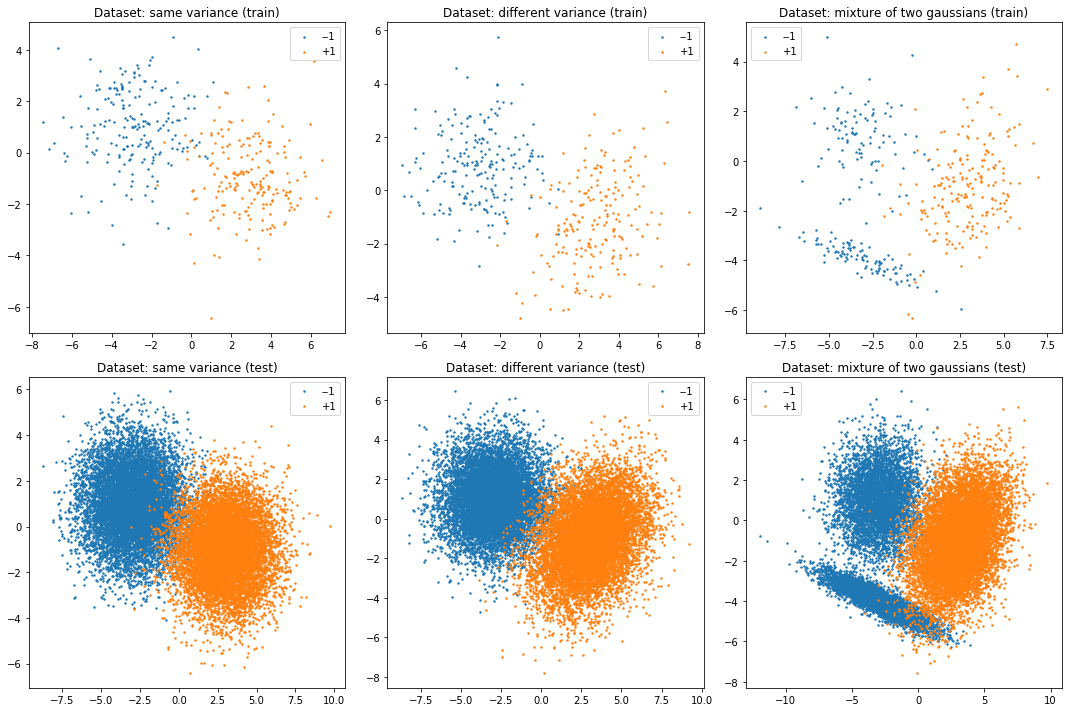

In [8]:
def data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3=None, Σ3=None):
    """
    Generates a dataset composed of two bivariate gaussian samples with different means.
    @param μ1 is the mean of the first sample (+1)
    @param Σ1 is the covariance matrix of the first sample (+1)
    @param μ2 is the mean of the second sample (-1)
    @param Σ2 is the covariance matrix of the second sample
    @param n_train is the number of points of each sample in the training set
    @param n_train is the number of points of each sample in the training set
    @param μ3 is the mean of the first sample (+1) (if provided, will make a mixture of gaussians)
    @param Σ3 is the covariance matrix of the first sample (+1) (if provided, will make a mixture of gaussians)
    @return ((x_train, y_train), (x_test, y_test))
    """
    def pos_examples(n):
        pos_examples = random.multivariate_normal(μ1, Σ1, n)
        if μ3 is not None:
            pos_examples[:n//2] = random.multivariate_normal(μ3, Σ3, n//2)
        return pos_examples
    def neg_examples(n):
        return random.multivariate_normal(μ2, Σ2, n)
    def generate(n):
        x = concatenate((pos_examples(n), neg_examples(n)), axis=0)
        y = concatenate((ones(n),         -ones(n)),        axis=0)
        return x,y
    return generate(n_train), generate(n_test)

def plot_dataset(dataset, test=False):
    """
    Plots training or testing points in the dataset.
    """
    x, y = dataset[int(test)]
    scatter(x[y ==  1][:, 0], x[y ==  1][:, 1], s=2, label="--1")
    scatter(x[y == -1][:, 0], x[y == -1][:, 1], s=2, label="+1")
    title("Dataset: {}".format(name))
    legend()

μ1 = array([-3, 1])
Σ1 = array([[2.5,0],[0,2]])
μ2 = array([3, -1])
Σ2 = array([[3, 1],[1, 3]])
μ3 = array([-3,-4])
Σ3 = array([[4,-1.25],[-1.25,0.5]])
n_train = 200
n_test = 10000
datasets = {
    "same variance":            data_points(μ1, Σ1, μ2, Σ1, n_train, n_test),
    "different variance":       data_points(μ1, Σ1, μ2, Σ2, n_train, n_test),
    "mixture of two gaussians": data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3, Σ3),
}
n_datasets = len(datasets)

figure(figsize=(5*n_datasets,10))
i = 0
for name in datasets:
    i += 1
    subplot(2, n_datasets, i)
    plot_dataset(datasets[name], test=False)
    title("Dataset: {} ({})".format(name, "train"))
    subplot(2, n_datasets, i+n_datasets)
    plot_dataset(datasets[name], test=True)
    title("Dataset: {} ({})".format(name, "test"))
tight_layout()

### Test functions

In [9]:
def plot_contours(results, xx, yy, **contourf_params):
    """
    Plot the decision boundaries of a classifier.
    @param results is the result dictionnary of a classifier
    @param xx is the meshgrid array
    @param yy is the meshgrid array
    @param contourf_params are the additional contourf parameters
    """
    z = results["predict"](c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    contourf(xx, yy, z, [-1, 0, 1], **contourf_params)
    contour( xx, yy, z, [-1, 0, 1], colors=["C1", "C7", "C0"])

def plot_results(axes, dataset_name, classifier_name, kernel_name, c=1, ɛ=1e-10):
    dataset = datasets[dataset_name]
    (x_train, y_train), (x_test, y_test) = dataset
    results = train(classifier_name, x_train, y_train, c, kernels[kernel_name], ɛ)
    
    plot_dataset(dataset)
    
    n_grid = 100
    x_min, x_max = axes.get_xlim()
    y_min, y_max = axes.get_ylim()
    xx, yy = meshgrid(linspace(x_min, x_max, n_grid), linspace(y_min, y_max, n_grid))
    plot_contours(results, xx, yy, cmap=plt.cm.coolwarm_r)
    
    scatter(results["support_vectors"][:, 0], results["support_vectors"][:, 1], s=10, linewidth=1, c='gray')
    title("Dataset: {}, classifier: {}\n{} kernel, C={:.0e}".format(
        dataset_name, classifier_name, kernel_name, c), fontsize="x-large")
    
    def accuracy(x, y):
        labels = results["predict_labels"](x)
        return mean(labels != y) * 100
    xlabel("Train Error: {:.2f}%      Test Error: {:.2f}%".format(
        accuracy(x_train, y_train), accuracy(x_test, y_test)), fontsize="large")
    
def plot_duality_gap(axes, dataset_name, classifier_name, kernel_name, c=1, ɛ=1e-10):
    dataset = datasets[dataset_name]
    (x_train, y_train), (x_test, y_test) = dataset
    results = train(classifier_name, x_train, y_train, c, kernels[kernel_name], ɛ)
    
    duality_gaps = results["duality_gaps"]
    plot(arange(len(duality_gaps)), duality_gaps)
    title("Dataset: {}, classifier: {}\n{} kernel, C={:.0e}".format(
        dataset_name, classifier_name, kernel_name, c), fontsize="x-large")
    xlabel("Number of steps", fontsize="x-large")
    ylabel("Duality gap", fontsize="x-large")

### Choice of kernel

Dataset: same variance, linear kernel
CPU times: user 12.8 s, sys: 13.6 s, total: 26.4 s
Wall time: 22.1 s
Dataset: same variance, affine kernel


KeyboardInterrupt: 

Dataset: same variance, exponential kernel


KeyboardInterrupt: 

Dataset: same variance, polynomial kernel


KeyboardInterrupt: 

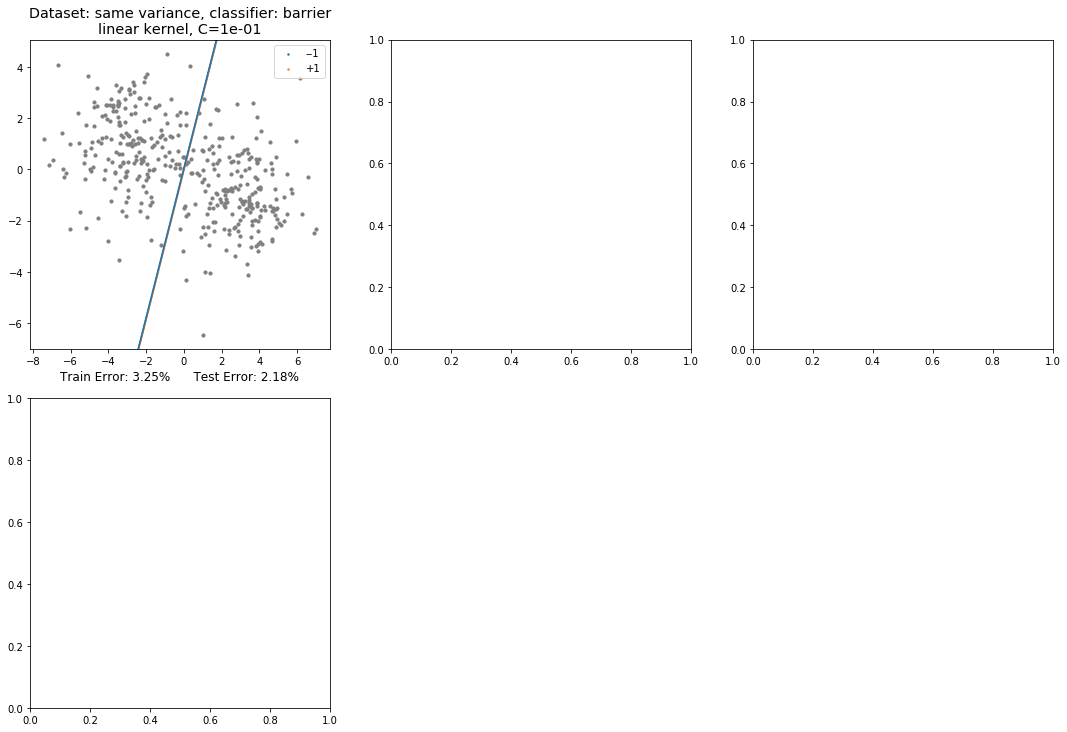

In [10]:
figure(figsize=(5*n_datasets,5*n_kernels))
i = 0
for kernel in kernels:
    for dataset in datasets:
        i += 1
        axes = subplot(n_kernels, n_datasets, i)
        print("Dataset: {}, {} kernel".format(dataset, kernel))
        %time plot_results(axes, dataset, "barrier", kernel, c=1e-1)
tight_layout()

# TODO commentary

### Influence of $C$

Dataset: same variance, C=0.001
CPU times: user 4.51 s, sys: 1.63 s, total: 6.14 s
Wall time: 1.64 s
Dataset: different variance, C=0.001
CPU times: user 5.26 s, sys: 1.88 s, total: 7.14 s
Wall time: 1.91 s
Dataset: mixture of two gaussians, C=0.001
CPU times: user 5.38 s, sys: 2.04 s, total: 7.41 s
Wall time: 2.02 s
Dataset: same variance, C=0.01
CPU times: user 4.52 s, sys: 1.44 s, total: 5.96 s
Wall time: 1.55 s
Dataset: different variance, C=0.01
CPU times: user 4.97 s, sys: 2.06 s, total: 7.03 s
Wall time: 1.91 s
Dataset: mixture of two gaussians, C=0.01
CPU times: user 5.27 s, sys: 2.17 s, total: 7.44 s
Wall time: 1.98 s
Dataset: same variance, C=0.1
CPU times: user 4.9 s, sys: 1.43 s, total: 6.33 s
Wall time: 1.64 s
Dataset: different variance, C=0.1
CPU times: user 4.47 s, sys: 1.79 s, total: 6.26 s
Wall time: 1.62 s
Dataset: mixture of two gaussians, C=0.1
CPU times: user 5.48 s, sys: 1.76 s, total: 7.25 s
Wall time: 1.92 s
Dataset: same variance, C=1.0
CPU times: user 4.57 s,

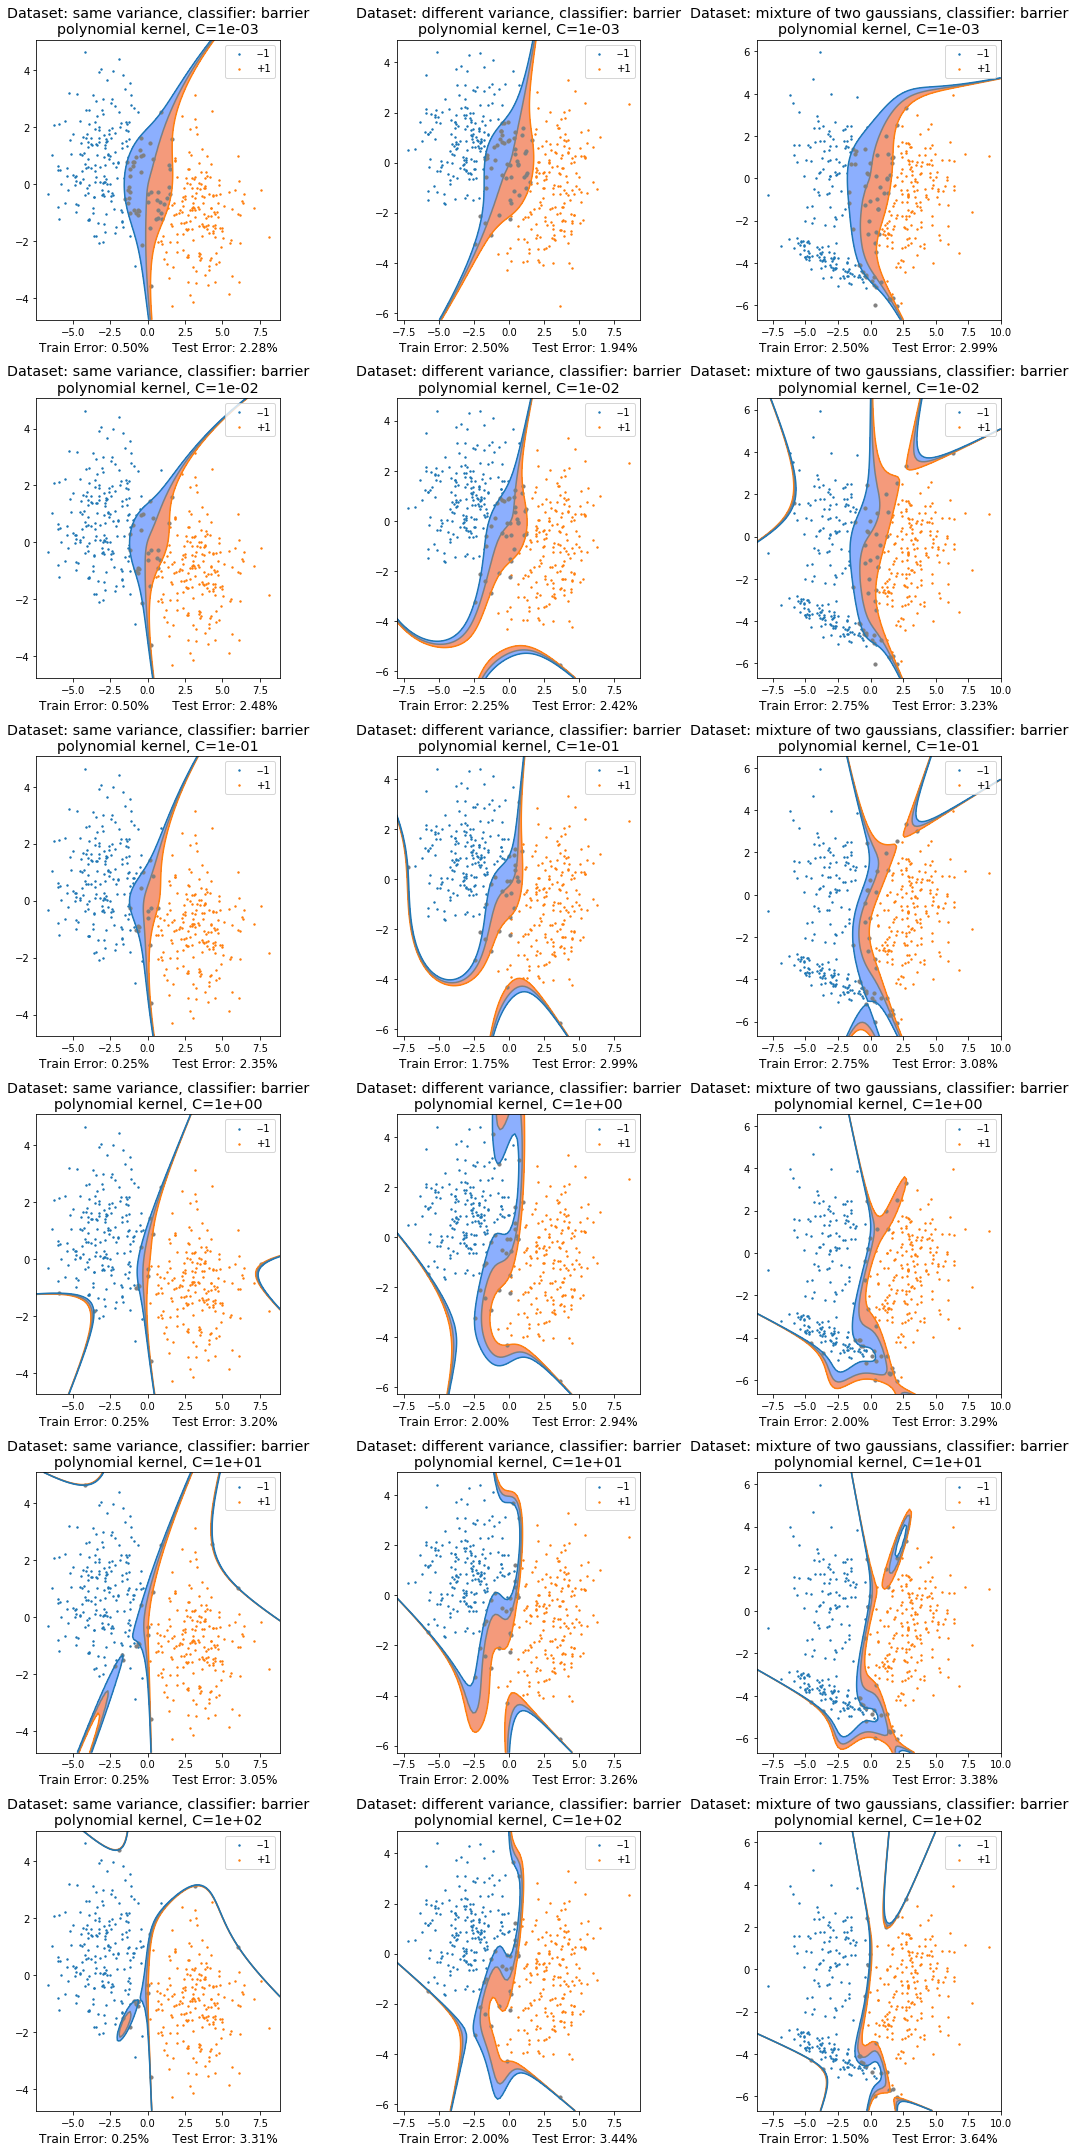

In [11]:
cs = 10.0**arange(-3,3)
n_cs = len(cs)

figure(figsize=(5*n_datasets,5*n_cs))
i = 0
for c in cs:
    for dataset in datasets:
        i += 1
        axes = subplot(n_cs, n_datasets, i)
        print("Dataset: {}, C={}".format(dataset, c))
        %time plot_results(axes, dataset, "barrier", "polynomial", c, c*1e-10)
tight_layout()

# TODO Commentary

### Comparison with other solvers

Dataset: same variance, barrier classifier
CPU times: user 3.74 s, sys: 1.61 s, total: 5.35 s
Wall time: 1.53 s
Dataset: different variance, barrier classifier
CPU times: user 3.77 s, sys: 938 ms, total: 4.7 s
Wall time: 1.23 s
Dataset: mixture of two gaussians, barrier classifier
CPU times: user 3.27 s, sys: 1.06 s, total: 4.33 s
Wall time: 1.13 s
Dataset: same variance, sklearn classifier
CPU times: user 41.3 ms, sys: 70.8 ms, total: 112 ms
Wall time: 30.5 ms
Dataset: different variance, sklearn classifier
CPU times: user 47.5 ms, sys: 59 ms, total: 106 ms
Wall time: 27.5 ms
Dataset: mixture of two gaussians, sklearn classifier
CPU times: user 63.8 ms, sys: 67.8 ms, total: 132 ms
Wall time: 36.7 ms
Dataset: same variance, cvxopt classifier
CPU times: user 371 ms, sys: 210 ms, total: 581 ms
Wall time: 153 ms
Dataset: different variance, cvxopt classifier
CPU times: user 436 ms, sys: 283 ms, total: 719 ms
Wall time: 198 ms
Dataset: mixture of two gaussians, cvxopt classifier
CPU times:

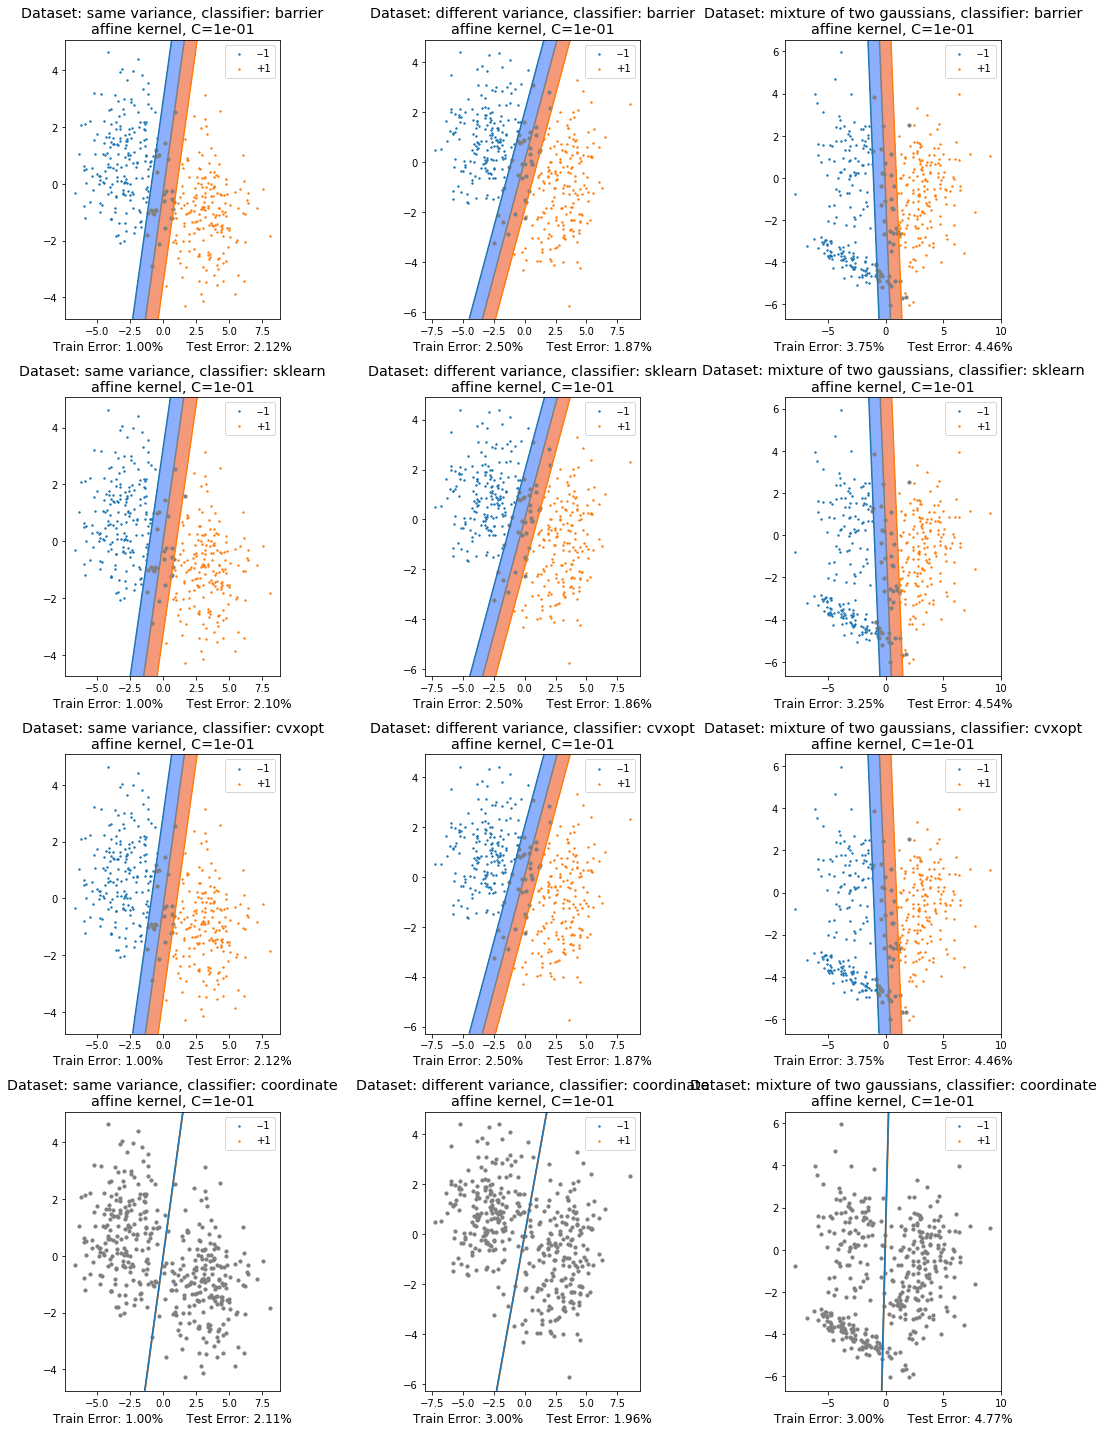

In [27]:
figure(figsize=(5*n_datasets,5*n_classifiers))
i = 0
for classifier in classifiers:
    for dataset in datasets:
        i += 1
        axes = subplot(n_classifiers, n_datasets, i)
        print("Dataset: {}, {} classifier".format(dataset, classifier))
        %time plot_results(axes, dataset, classifier, "affine", c=1e-1)
tight_layout()

# TODO Commentary

### Duality Gap

Dataset: same variance, barrier classifier
CPU times: user 2.38 s, sys: 717 ms, total: 3.09 s
Wall time: 835 ms
Dataset: different variance, barrier classifier
CPU times: user 2.83 s, sys: 1.04 s, total: 3.86 s
Wall time: 1.1 s
Dataset: mixture of two gaussians, barrier classifier
CPU times: user 3.74 s, sys: 1.67 s, total: 5.41 s
Wall time: 1.75 s
Dataset: same variance, coordinate classifier
CPU times: user 15.6 ms, sys: 17.5 ms, total: 33.1 ms
Wall time: 8.5 ms
Dataset: different variance, coordinate classifier
CPU times: user 17.1 ms, sys: 16.4 ms, total: 33.5 ms
Wall time: 8.47 ms
Dataset: mixture of two gaussians, coordinate classifier
CPU times: user 9.6 ms, sys: 23.6 ms, total: 33.2 ms
Wall time: 8.67 ms


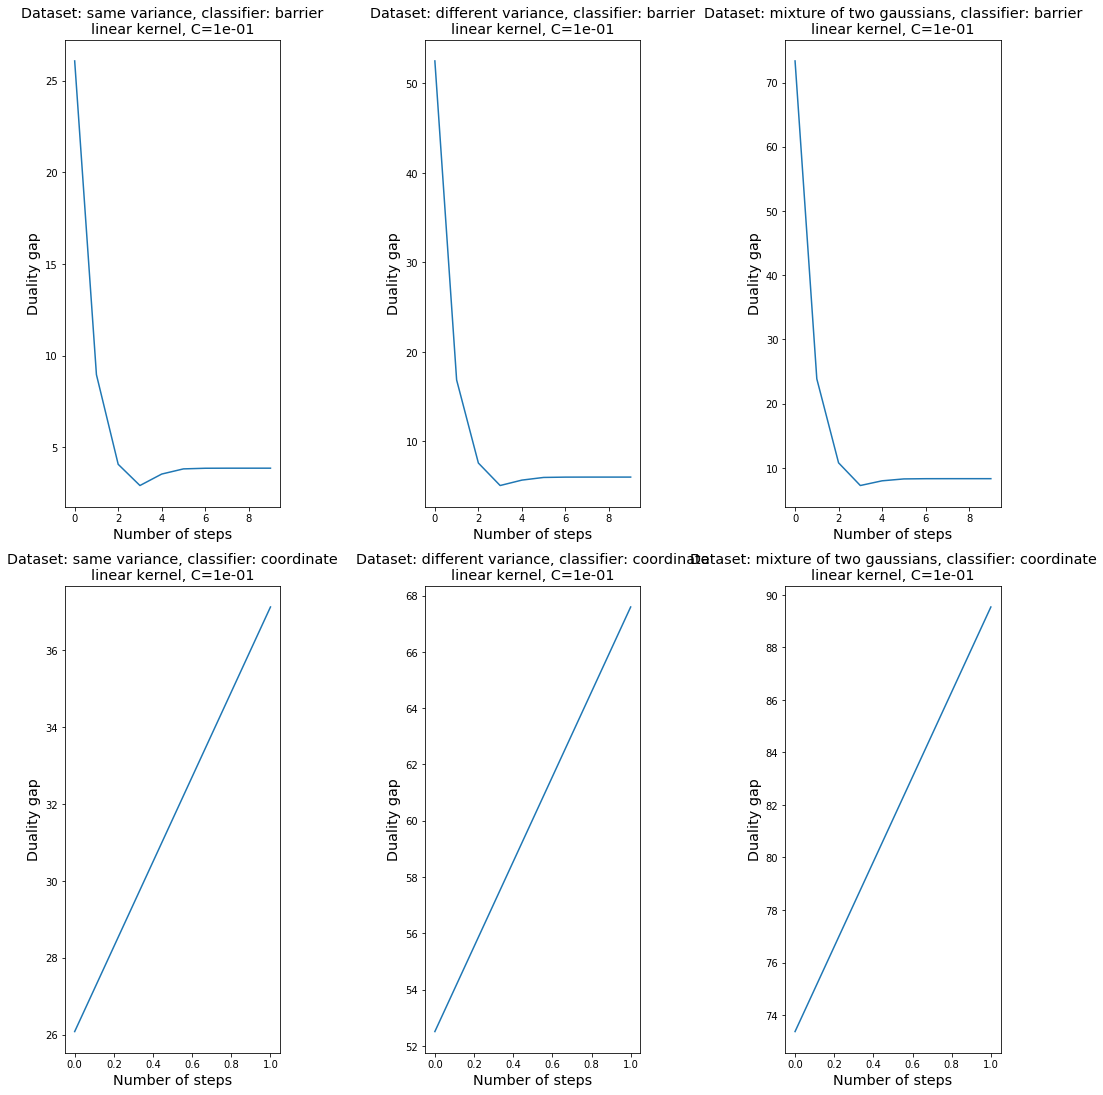

In [28]:
figure(figsize=(5*n_datasets,2*15))
i = 0
for classifier in ["barrier", "coordinate"]:
    for dataset in datasets:
        i += 1
        axes = subplot(n_classifiers, n_datasets, i)
        print("Dataset: {}, {} classifier".format(dataset, classifier))
        %time plot_duality_gap(axes, dataset, classifier, "linear", c=1e-1, ɛ=1e-6)
tight_layout()

# TODO commentary, why doesn't it decreases to 0?
And compare with coordinate descent:
Use the coordinate descent method to solve the dual. Plot duality gap versus iteration number and compare performance with the barrier method for various problem sizes (vary the number of samples and record to total CPU time required by each code to reduce the gap by a factor ${10}^{-3}$).

/home/kegnarok/.local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


CPU times: user 588 ms, sys: 591 ms, total: 1.18 s
Wall time: 490 ms


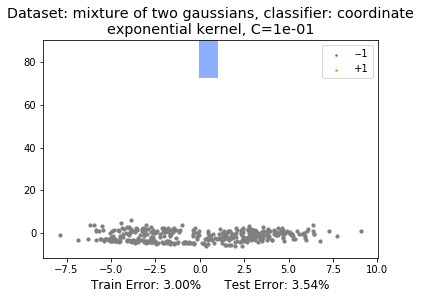

/home/kegnarok/.local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


CPU times: user 3.72 s, sys: 1.99 s, total: 5.71 s
Wall time: 1.62 s


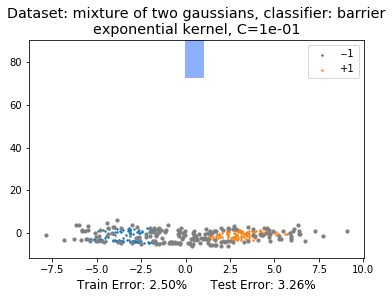

In [29]:
%time plot_results(axes, dataset, "coordinate", "exponential", c=1e-1)
plt.show()
%time plot_results(axes, dataset, "barrier", "exponential", c=1e-1)

# TODO
Use the logarithmic barrier code you wrote in HW1 to solve a small random instance of the primal problem using the ACCPM algorithm. Plot an upper bound on the distance to optimality in semilog scale and try various constraint dropping strategies. Compare convergence with the two other methods.

In [14]:
def logarithmic_barrier(a, b, c, ɛ, **barrier_params):
    """
    Solve the following linear program: minimize c^T x subject to Ax <= b using the logarithmic barrier method.
    @param a is an array of shape (m,n)
    @param b is an array of shape m
    @param c is an array of shape n
    @param ɛ is the required absolute precision
    @param barrier_params are the additional barrier method parameters
    @return a dictionnary, with at least the α field
    """
    (m, n) = a.shape
    # Build the tensor of the a_i a_i^T (shape m,n,n).
    scalars = einsum('ij,ik->ijk', a, a)
    
    def objective(x):
        return c.dot(x)
    def objective_gh(x):
        return c, zeros((n, n))
    def constraints(x):
        return a.dot(x) - b
    def constraints_gh(x):
        gradients = a
        hessians = zeros((m, n, n))
        return gradients, hessians
    
    return barrier_phase_one(n, objective, objective_gh, m, constraints, constraints_gh, ɛ, **barrier_params)

# TEMP: logarithmic barrier test

In [15]:
def bounded_polytope(n, m):
    """ Returns a, b and x0 such that a and b describe a bounded polytope in dimension n with at least
    m constraints containing x0. """
    a = 2*random.random((m + 2*n, n)) - 1
    b = random.random(m + 2*n)
    # To ensure the polytope is bounded, we make its intersection with [-1,1]^d.
    eis = eye(n)
    a[m:] = concatenate((eis, -eis))
    b[m:] = ones(2*n)
    # Since all b_i's are positive (almost surely), 0 is in the domain of f
    # (this also guarantees that it is not empty).
    x0 = zeros(n)
    return a, b, x0

def random_conditions(n, m):
    a, b, _ = bounded_polytope(n, m)
    # We offset the polytope so zero is not strictly feasible anymore.
    center = 10*random.random(n)
    b += a.dot(center)
    c = 2*random.random(n) - 1
    return a, b, c, center

def plot_constraint(a, b, center):
    """ Plots (on the current plot) the line a^T x = b. """
    if a[1] == 0:
        # Vertical line.
        if a[0] != 0:
            plot([b/a[0], b/a[0]], [center[1]-2, center[1]+2])
    else:
        plot([center[0]-2, center[0]+2], [(b - (center[0]-2)*a[0])/a[1], (b - (center[0]+2)*a[0])/a[1]])

def plot_constraints(a, b, center=[0,0]):
    for i in range(len(b)):
        plot_constraint(a[i], b[i], center)
        
def plot_results(a, b, center, results):
    figure(figsize=(8,8))
    rc('text', usetex=True)
    [x_star, y_star] = results["primal_solution"]
    plot(x_star, y_star, '.', color='black')
    text(x_star, y_star, r"$x^*$", fontsize=24)
    plot_constraints(a, b, center)
    xlim(center[0] - 1.1, center[0] + 1.1)
    ylim(center[1] - 1.1, center[1] + 1.1)
        
def plot_central_path(m):
    a, b, c, center = random_conditions(2, m)
    results = logarithmic_barrier(a, b, c, ɛ=1e-10)
    plot_path(a, b, center, results)
    [x_star, y_star] = results["primal_solution"]
    arrow(x_star, y_star, c[0]/(5*norm(c)), c[1]/(5*norm(c)), color="red", width=0.02, label="c")

plot_central_path(10)

14 2 (14, 2, 2)
14 2 (14, 3) (14, 3, 3)


LinAlgError: Singular matrix